In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from scipy.stats import norm

In [2]:
def qq_plot(x):
    n = len(x)
    x = pd.Series(x)
    sample = ((x - x.mean())/x.std()).sort_values(ascending=True)
    theoretical = [norm.ppf((k+0.5)/n) for k in range(n)]
    plt.scatter(x=theoretical,y=sample)
    plt.axline((0,0), slope=1, color="darksalmon")
    plt.show()

In [3]:
# preprocessing
def normalise(df):
    return (df - df.mean())/df.std()

def boxcox_transform(df, lambdas=None):
    bc = pd.DataFrame()
    bc_lambdas = []
    for i, c in enumerate(df.columns):
        if lambdas is None:
            a, b = boxcox(df[c])
            bc_lambdas.append(b)
        else:
            a = boxcox(df[c], lmbda=lambdas[i])
        a = pd.Series(a, name=c, index=df.index)
        bc = pd.concat([bc, a], axis="columns")
    return bc, bc_lambdas

## 6.1

**The theory of IR spectroscopy holds that unique molecular structures absorb IR frequencies differently. In practice a spectrometer fires a series of IR frequencies into a sample material, and the device measures the absorbance of the sample at each individual frequency. This series of measurements creates a spectrum profile which can then be used to determine the chemical makeup of the sample material.**

**A Tecator Infratec Food and Feed Analyzer instrument was used to analyze 215 samples of meat across 100 frequencies. A sample of these frequency profiles is displayed in Fig. 6.20. In addition to an IR profile, analytical chemistry determined the percent content of water, fat, and protein for each sample.**

**(a) Load the data**

**(b) In this example the predictors are the measurements at the individual fre-quencies. Because the frequencies lie in a systematic order (850–1,050 nm), the predictors have a high degree of correlation. Hence, the data lie in a smaller dimension than the total number of predictors (100). Use PCA to determine the effective dimension of these data. What is the effective dimension?**

Variance explained by first 10 components of PCA\
0 - 26.1271\
1 - 0.2385\
2 - 0.0784\
3 - 0.0302\
4 - 0.0015\
5 - 0.0007\
6 - 0.0002\
7 - 0.0001\
8 - 0.0000\
9 - 0.0000

Used boxcox transform and normalisation to reduce skewness. Variation explained remains same ratio.

The effective dimention of PCA is 1.

**(c) Split the data into a training and a test set, pre-process the data, and build each variety of models described in this chapter. For those models with tuning parameters, what are the optimal values of the tuning parameter(s)?**

**(d) Which model has the best predictive ability? Is any model significantly better or worse than the others?**

The boxcox transformation on predictor variables significantly improves the predictive ability for all models tested (ols, pcr, pls, l1 and l2 penalised regression)

The performance of models is a function of the train/val/test split. I performed 300 bootstraps of the training dataset to find the performance independent of train/val/test split.

Out of all the models, l2 penalised regression after boxcox transformation is consistently better than all the other alternatives. The performance at every quartile range was better for l2 penalised regression than any other model.


**(e) Explain which model you would use for predicting the fat content of a sample.**

L2 penalised regression after boxcox transformation.

In [4]:
# Reading in data

absorb = pd.read_csv("/home/roger/code/applied-predictive-modeling/data/absorb.csv", index_col="id", header=0)
endpoints = pd.read_csv("/home/roger/code/applied-predictive-modeling/data/endpoints.csv", index_col="id", header=0)
endpoints=endpoints.rename(columns=
    {"V2":"fat"})
absorb = pd.concat([absorb, endpoints[["fat"]]], axis="columns")

In [5]:
pca = PCA()
pca.fit(absorb.drop(columns="fat"))

PCA()

In [6]:
print("Total:", pca.explained_variance_.sum())
for i, var in enumerate(pca.explained_variance_[:10]):
    print(i, f"{var:.4f}")

Total: 26.476848832131623
0 26.1271
1 0.2385
2 0.0784
3 0.0302
4 0.0015
5 0.0007
6 0.0002
7 0.0001
8 0.0000
9 0.0000


In [7]:
absorb_n = (absorb - absorb.mean())/absorb.std()
absorb_n["fat"] = absorb["fat"]

In [8]:
pca_n = PCA()
pca_n.fit(absorb_n.drop(columns="fat"))

PCA()

In [9]:
for i, var in enumerate(pca.explained_variance_[:10]):
    print(i, f"{var:.4f}")

0 26.1271
1 0.2385
2 0.0784
3 0.0302
4 0.0015
5 0.0007
6 0.0002
7 0.0001
8 0.0000
9 0.0000


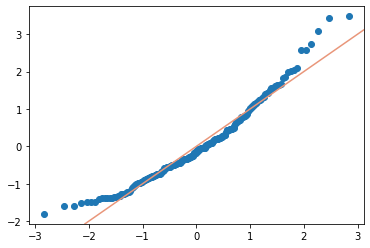

In [10]:
# qq plot for untransformed variable
qq_plot(absorb_n["V1"])

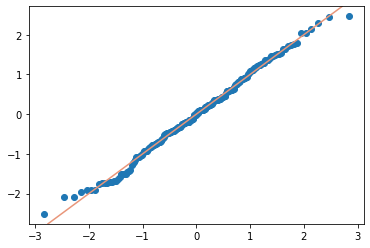

In [11]:
# qq plot for box cox transformed variable
x_bc, l = boxcox(absorb["V1"])
qq_plot(x_bc)

In [12]:
# use boxcox to transform all variables, what effect does this have on PCA?

absorb_bc = pd.DataFrame()
bc_lambdas = []
for c in absorb.columns:
    a, b = boxcox(absorb[c])
    a = pd.Series(a, name=c, index=absorb.index)
    absorb_bc = pd.concat([absorb_bc, a], axis="columns")
    bc_lambdas.append(b)
absorb_bc["fat"] = absorb["fat"]

In [13]:
pca_bc = PCA()
pca_bc.fit(absorb_bc.drop(columns="fat"))

PCA()

In [14]:
for i, var in enumerate(pca_bc.explained_variance_[:10]):
    print(i, f"{var:.4f}")

0 0.1585
1 0.0012
2 0.0004
3 0.0001
4 0.0000
5 0.0000
6 0.0000
7 0.0000
8 0.0000
9 0.0000


In [15]:
# With/without standardisation + boxcox
# Ordinary Least Squares
# PCA
# PLS
# squared regularisation
# abs regularisation

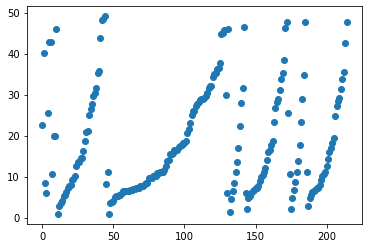

In [16]:
# checking for patterns in target variable
# looks like data is not randomised
plt.scatter(x=range(len(absorb["fat"])), y=absorb["fat"])
plt.show()

In [17]:
# training/validation/test
no_transform = {}

no_transform["train_val"], no_transform["test"] = train_test_split(absorb, test_size=0.2)
no_transform["train"], no_transform["val"] = train_test_split(no_transform["train_val"], test_size=0.25)

y = {}
for key in no_transform:
    y[key] = no_transform[key]["fat"]
    no_transform[key] = no_transform[key].drop(columns="fat")

In [18]:
normalised = {}
for key in no_transform:
    normalised[key] = normalise(no_transform[key])

bc_transformed = {}
bc_transformed["train"], lambdas = boxcox_transform(no_transform["train"])
for key in [e for e in no_transform if e != "train"]:
    bc_transformed[key], _ = boxcox_transform(no_transform[key], lambdas)

In [19]:
# Ordinary Least Squares
ols_no_preprocessing = linear_model.LinearRegression()
ols_normalise = linear_model.LinearRegression(normalize=True)
ols_boxcox = linear_model.LinearRegression(normalize=True)

In [20]:
# Training
ols_no_preprocessing.fit(X=no_transform["train_val"], y=y["train_val"])
ols_normalise.fit(X=no_transform["train_val"], y=y["train_val"])
ols_boxcox.fit(X=bc_transformed["train_val"], y=y["train_val"])

LinearRegression(normalize=True)

In [21]:
# Testing
print(f'Ordinary Least Squares without preprocessing R2: {ols_no_preprocessing.score(X=no_transform["test"], y=y["test"]):.4f}')
print(f'Ordinary Least Squares with normalisation R2: {ols_normalise.score(X=no_transform["test"], y=y["test"]):.4f}')

# boxcox transform
print(f'Ordinary Least Squares with norm & boxcox R2: {ols_boxcox.score(X=bc_transformed["test"], y=y["test"]):.4f}')

Ordinary Least Squares without preprocessing R2: 0.8204
Ordinary Least Squares with normalisation R2: 0.8204
Ordinary Least Squares with norm & boxcox R2: 0.9569


In [22]:
pca_scores = []

for n_components in range(1, min(bc_transformed["train"].shape)-1):
    pca_x = {}
    pca = PCA(n_components=n_components)
    ols_pca = linear_model.LinearRegression()

    pca_x["train"] = pca.fit_transform(bc_transformed["train"])
    pca_x["val"] = pca.transform(bc_transformed["val"])
    pca_x["test"] = pca.transform(bc_transformed["test"])

    ols_pca.fit(X=pca_x["train"], y=y["train"])
    pca_scores.append(ols_pca.score(X=pca_x["val"], y=y["val"]))
    
n = pca_scores.index(max(pca_scores))+1
pca_final = PCA(n_components=n)
pca_x["train_val"] = pca_final.fit_transform(bc_transformed["train_val"])
pca_x["test"] = pca_final.transform(bc_transformed["test"])
ols_pca.fit(pca_x["train_val"], y["train_val"])

print(f'pca test score {ols_pca.score(pca_x["test"], y["test"]):.4f}')

pca test score 0.9776


In [23]:
# PLS
# Loop through top X components
# Fit regression
# Find R2 on test set
# Graph
pls_scores = []

for n_components in range(1, min(bc_transformed["train"].shape)-1):
    pls = PLSRegression(n_components=n_components)

    pls_x = {}
    pls.fit(bc_transformed["train"], y["train"])
    pls_scores.append(pls.score(X=bc_transformed["val"], y=y["val"]))

# Select number of components with highest R2 score
# Fit regression on training and validation set
# Score on test set
n = pls_scores.index(max(pls_scores))+1
pls_final = PLSRegression(n_components=n)
pls.fit(bc_transformed["train_val"], y["train_val"])
print(f'pls test score {pls.score(X=bc_transformed["test"], y=y["test"]):.4f}')

pls test score 0.9569


In [24]:
# Penalised Regression

alphas = []
scores_l1 = []
scores_l2 = []
for i in range(-30, 0):
    alpha = 10**(i/4)
    alphas.append(alpha)
    ols_l1 = linear_model.Lasso(alpha=alpha, max_iter=10_000)
    ols_l2 = linear_model.Ridge(alpha=alpha, max_iter=10_000)
    ols_l1.fit(bc_transformed["train"], y["train"])
    ols_l2.fit(bc_transformed["train"], y["train"])
    scores_l1.append(ols_l1.score(bc_transformed["val"], y["val"]))
    scores_l2.append(ols_l2.score(bc_transformed["val"], y["val"]))

alpha_l1 = alphas[scores_l1.index(max(scores_l1))]
alpha_l2 = alphas[scores_l2.index(max(scores_l2))]
ols_l1 = linear_model.Lasso(alpha=alpha_l1, max_iter=10_000)
ols_l2 = linear_model.Ridge(alpha=alpha_l2, max_iter=10_000)
ols_l1.fit(bc_transformed["train_val"], y["train_val"])
ols_l2.fit(bc_transformed["train_val"], y["train_val"])
print(f'l1 regularisation: {ols_l1.score(bc_transformed["test"], y["test"])}')
print(f'l2 regularisation: {ols_l2.score(bc_transformed["test"], y["test"])}')

/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 552.232487448753, tolerance: 2.12826303875969
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 552.2142085281138, tolerance: 2.12826303875969
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 552.1816922927308, tolerance: 2.12826303875969
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.p

l1 regularisation: 0.9234142148934582
l2 regularisation: 0.9790229566840396


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 752.7815810476146, tolerance: 2.8100504360465117
  model = cd_fast.enet_coordinate_descent(


In [25]:
# Boostrapping R2 with different train/val/test splits
# Creating split
train_val, test = train_test_split(absorb, test_size=0.2)
train, val = train_test_split(train_val, test_size=0.25)
ds = {}
ds["x_train"] = train.drop(columns="fat")
ds["x_val"] = val.drop(columns="fat")
ds["x_train_val"] = train_val.drop(columns="fat")
ds["x_test"] = test.drop(columns="fat")
ds["y_train"] = train["fat"]
ds["y_val"] = val["fat"]
ds["y_train_val"] = train_val["fat"]
ds["y_test"] = test["fat"]

In [26]:
def ols(ds):
    ols = linear_model.LinearRegression()
    ols.fit(X=ds["x_train_val"], y=ds["y_train_val"])
    return ols.score(X=ds["x_test"], y=ds["y_test"])

In [27]:
ols(ds)

0.8791459111177173

In [28]:
def ols_bc(ds):
    ols_boxcox = linear_model.LinearRegression(normalize=True)
    train_val_bc, lambdas = boxcox_transform(ds["x_train_val"])
    ols_boxcox.fit(X=train_val_bc, y=ds["y_train_val"])
    test_bc, _ = boxcox_transform(ds["x_test"], lambdas=lambdas)
    return ols_boxcox.score(X=test_bc, y=ds["y_test"])

In [29]:
ols_bc(ds)

0.9817259357978549

In [37]:
def pca(ds, boxcox=False):
    pca_scores = []
    
    if boxcox:
        ds_bc = {}
        ds_bc["x_train"], lambdas = boxcox_transform(ds["x_train"])
        ds_bc["x_val"], _ = boxcox_transform(ds["x_val"], lambdas=lambdas)
        ds_bc["x_train_val"], lambdas = boxcox_transform(ds["x_train_val"])
        ds_bc["x_test"], _ = boxcox_transform(ds["x_test"], lambdas=lambdas)
    else:
        ds_bc = ds
    
    for n_components in range(1, min(ds_bc["x_train"].shape)-1):
        pca_x = {}
        pca = PCA(n_components=n_components)
        ols_pca = linear_model.LinearRegression()

        pca_x["train"] = pca.fit_transform(ds_bc["x_train"])
        pca_x["val"] = pca.transform(ds_bc["x_val"])
        pca_x["test"] = pca.transform(ds_bc["x_test"])

        ols_pca.fit(X=pca_x["train"], y=ds["y_train"])
        pca_scores.append(ols_pca.score(X=pca_x["val"], y=ds["y_val"]))

    n = pca_scores.index(max(pca_scores))+1
    pca_final = PCA(n_components=n)
    pca_x["train_val"] = pca_final.fit_transform(ds_bc["x_train_val"])
    pca_x["test"] = pca_final.transform(ds_bc["x_test"])
    ols_pca.fit(pca_x["train_val"], ds["y_train_val"])

    return ols_pca.score(pca_x["test"], ds["y_test"])

In [38]:
def pls(ds, boxcox=False):
    pls_scores = []

    if boxcox:
        ds_bc = {}
        ds_bc["x_train"], lambdas = boxcox_transform(ds["x_train"])
        ds_bc["x_val"], _ = boxcox_transform(ds["x_val"], lambdas=lambdas)
        ds_bc["x_train_val"], lambdas = boxcox_transform(ds["x_train_val"])
        ds_bc["x_test"], _ = boxcox_transform(ds["x_test"], lambdas=lambdas)
    else:
        ds_bc = ds
    
    for n_components in range(1, min(ds_bc["x_train"].shape)-1):
        pls = PLSRegression(n_components=n_components)
        ols_pls = linear_model.LinearRegression()

        pls_x = {}
        pls.fit(ds_bc["x_train"], ds["y_train"])
        pls_scores.append(pls.score(X=ds_bc["x_val"], y=ds["y_val"]))

    # Select number of components with highest R2 score
    # Fit regression on training and validation set
    # Score on test set
    n = pls_scores.index(max(pls_scores))+1
    pls_final = PLSRegression(n_components=n)
    pls_final.fit(ds_bc["x_train_val"], ds["y_train_val"])
    return pls_final.score(X=ds_bc["x_test"], y=ds["y_test"])

In [34]:
def penalised_regression(ds, model):
    ds_bc = {}
    ds_bc["x_train"], lambdas = boxcox_transform(ds["x_train"])
    ds_bc["x_val"], _ = boxcox_transform(ds["x_val"], lambdas=lambdas)
    ds_bc["x_train_val"], lambdas = boxcox_transform(ds["x_train_val"])
    ds_bc["x_test"], _ = boxcox_transform(ds["x_test"], lambdas=lambdas)
    
    scores = []
    alphas = [10**(i/4) for i in range(-30, 0)]
    for alpha in alphas:
        penalised_reg = model(alpha=alpha, max_iter=10_000)
        penalised_reg.fit(ds_bc["x_train"], ds["y_train"])
        scores.append(penalised_reg.score(ds_bc["x_val"], ds["y_val"]))

    best_alpha = alphas[scores.index(max(scores))]
    final_model = model(alpha=best_alpha, max_iter=10_000)
    final_model.fit(ds_bc["x_train_val"], ds["y_train_val"])
    return final_model.score(ds_bc["x_test"], ds["y_test"])


In [44]:
# Main bootstrap loop
# Sample train/val/test datasets from absorb
# Todo: Try adding boxcox to pca/pls
# Todo: Add way to record hyperparameters

trials = 300
results = pd.DataFrame()

for i in range(trials):
    train_val, test = train_test_split(absorb, test_size=0.2)
    train, val = train_test_split(train_val, test_size=0.25)
    ds = {}
    ds["x_train"] = train.drop(columns="fat")
    ds["x_val"] = val.drop(columns="fat")
    ds["x_train_val"] = train_val.drop(columns="fat")
    ds["x_test"] = test.drop(columns="fat")
    ds["y_train"] = train["fat"]
    ds["y_val"] = val["fat"]
    ds["y_train_val"] = train_val["fat"]
    ds["y_test"] = test["fat"]

    results = results.append({
        "ols":ols(ds),
        "ols_bc": ols_bc(ds),
        "pca": pca(ds),
        "pca_bc": pca(ds, boxcox=True),
        "pls": pls(ds),
        "pls_bc": pls(ds, boxcox=True),
        "l1": penalised_regression(ds, linear_model.Lasso),
        "l2": penalised_regression(ds, linear_model.Ridge)
    }, ignore_index=True)
    print(i)

/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 546.8871434889173, tolerance: 1.9590160155038758
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 546.8919270854237, tolerance: 1.9590160155038758
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 546.9004660250707, tolerance: 1.9590160155038758
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

0


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 586.7283541401656, tolerance: 1.985717968992248
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 586.7322310681933, tolerance: 1.985717968992248
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 586.739051666692, tolerance: 1.985717968992248
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descen

1


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 643.2075515582846, tolerance: 2.080852387596899
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 643.1877614427661, tolerance: 2.080852387596899
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 643.1525299199403, tolerance: 2.080852387596899
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

2


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 520.9874404257167, tolerance: 1.9354277209302329
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 520.9755210557217, tolerance: 1.9354277209302329
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 520.9542842103796, tolerance: 1.9354277209302329
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

3


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 630.2054681058935, tolerance: 2.255573488372093
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 630.182816224505, tolerance: 2.255573488372093
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 630.1422839015158, tolerance: 2.255573488372093
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descen

4


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 600.2568784133806, tolerance: 1.8602293953488374
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 600.260291965666, tolerance: 1.8602293953488374
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 600.2663356533036, tolerance: 1.8602293953488374
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

5


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 589.0526590153645, tolerance: 2.086903596899225
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 589.052321597417, tolerance: 2.086903596899225
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 589.0515226835856, tolerance: 2.086903596899225
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descen

6


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 521.2595176333851, tolerance: 1.8737142325581395
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 521.2545529830359, tolerance: 1.8737142325581395
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 521.245606543688, tolerance: 1.8737142325581395
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

7


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 570.5312061084398, tolerance: 2.101703209302326
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 570.5285698113578, tolerance: 2.101703209302326
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 570.5237869874754, tolerance: 2.101703209302326
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

8


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 502.94820001157944, tolerance: 1.935290558139535
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 502.93260457435576, tolerance: 1.935290558139535
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 502.90473817165724, tolerance: 1.935290558139535
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

9


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 471.2251564671441, tolerance: 2.0026580155038762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 471.2236696476696, tolerance: 2.0026580155038762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 471.22100448059444, tolerance: 2.0026580155038762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_d

10


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 531.8358079980894, tolerance: 1.9051469922480622
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 531.8052832210936, tolerance: 1.9051469922480622
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 531.7509125521045, tolerance: 1.9051469922480622
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

11


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 595.1587240496833, tolerance: 2.294223534883721
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 595.1216700864946, tolerance: 2.294223534883721
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 595.0556910673907, tolerance: 2.294223534883721
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

12


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 583.7896794884069, tolerance: 2.314279875968993
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 583.7837413441198, tolerance: 2.314279875968993
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 583.7731815071094, tolerance: 2.314279875968993
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

13


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 546.7944117592266, tolerance: 1.8677948062015506
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 546.7582646704407, tolerance: 1.8677948062015506
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 546.6938757436407, tolerance: 1.8677948062015506
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

14


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 619.2332565997302, tolerance: 1.848191596899225
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 619.1415179661799, tolerance: 1.848191596899225
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 618.978560242835, tolerance: 1.848191596899225
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descen

15


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 605.4801754977143, tolerance: 1.9050149922480626
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 605.4612509111386, tolerance: 1.9050149922480626
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 605.4275441611065, tolerance: 1.9050149922480626
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

16


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 595.3608831343555, tolerance: 2.2138132558139536
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 595.3394582531153, tolerance: 2.2138132558139536
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 595.3013175383733, tolerance: 2.2138132558139536
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

17


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 550.6350658377835, tolerance: 2.1965153488372096
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 550.6395791417735, tolerance: 2.1965153488372096
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 550.6470953320469, tolerance: 2.1965153488372096
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

18


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 460.02605514523, tolerance: 2.112300992248062
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 460.0303230634138, tolerance: 2.112300992248062
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 460.0378572426006, tolerance: 2.112300992248062
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent

19


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 507.785395847076, tolerance: 2.0218953953488374
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 507.7707340543832, tolerance: 2.0218953953488374
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 507.7446513197133, tolerance: 2.0218953953488374
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

20


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 518.5376056616872, tolerance: 2.2504817209302326
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 518.52788203383, tolerance: 2.2504817209302326
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 518.510547863783, tolerance: 2.2504817209302326
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

21


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 774.3263433920698, tolerance: 2.1765359224806207
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 774.3121565088351, tolerance: 2.1765359224806207
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 774.2868933859879, tolerance: 2.1765359224806207
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

22


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 599.5275735798031, tolerance: 2.2145303720930234
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 599.5148054466517, tolerance: 2.2145303720930234
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 599.4920347141157, tolerance: 2.2145303720930234
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

23


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 513.9874228747677, tolerance: 2.0108828992248062
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 513.9872446980553, tolerance: 2.0108828992248062
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 513.9868881152639, tolerance: 2.0108828992248062
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

24


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 460.7756911205458, tolerance: 2.101879953488372
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 460.768393386575, tolerance: 2.101879953488372
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 460.7553611195422, tolerance: 2.101879953488372
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descen

25


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 484.34583936462104, tolerance: 1.781192992248062
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 484.3598416556121, tolerance: 1.781192992248062
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 484.3846841474975, tolerance: 1.781192992248062
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desc

26


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 548.4183054013699, tolerance: 1.8756407596899227
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 548.376197630244, tolerance: 1.8756407596899227
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 548.3018598896288, tolerance: 1.8756407596899227
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

27


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 701.4514454611798, tolerance: 1.9820054883720932
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 701.2950465667354, tolerance: 1.9820054883720932
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 701.0166791133307, tolerance: 1.9820054883720932
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

28


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 476.06257056494155, tolerance: 2.0969076899224808
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 476.0454062542813, tolerance: 2.0969076899224808
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 476.0148268719063, tolerance: 2.0969076899224808
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_d

29


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 574.8751281771447, tolerance: 2.258186201550388
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 574.769815520997, tolerance: 2.258186201550388
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 574.581965881709, tolerance: 2.258186201550388
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent

30


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 526.3607067801522, tolerance: 2.032875209302326
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 526.3621316860983, tolerance: 2.032875209302326
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 526.3646108404723, tolerance: 2.032875209302326
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

31


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 487.71061201975283, tolerance: 2.081476062015504
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 487.7178186503508, tolerance: 2.081476062015504
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 487.7306054995269, tolerance: 2.081476062015504
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desc

32


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 532.7253591031375, tolerance: 2.19987903875969
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 532.7165150452834, tolerance: 2.19987903875969
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 532.7007174712408, tolerance: 2.19987903875969
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.

33


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 592.3048389058572, tolerance: 2.0025912558139534
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 592.3067170576038, tolerance: 2.0025912558139534
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 592.3098226892358, tolerance: 2.0025912558139534
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

34


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 562.6214661483847, tolerance: 2.061232015503876
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 562.6515864279088, tolerance: 2.061232015503876
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 562.7050331558333, tolerance: 2.061232015503876
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

35


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 627.8293648337702, tolerance: 2.2986828062015507
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 627.8077532177529, tolerance: 2.2986828062015507
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 627.7692730368348, tolerance: 2.2986828062015507
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

36


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 482.77584623741154, tolerance: 2.202605550387597
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 482.77332656425966, tolerance: 2.202605550387597
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 482.76877290867094, tolerance: 2.202605550387597
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

37


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 614.5090859589305, tolerance: 2.0434522015503878
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 614.4587121204333, tolerance: 2.0434522015503878
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 614.3689898289167, tolerance: 2.0434522015503878
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

38


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 509.9341510409153, tolerance: 1.9066349922480623
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 509.9461209182255, tolerance: 1.9066349922480623
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 509.96750764376577, tolerance: 1.9066349922480623
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_d

39


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 472.8207633588033, tolerance: 2.2775319224806205
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 472.7733635497256, tolerance: 2.2775319224806205
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 472.6888184173218, tolerance: 2.2775319224806205
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

40


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 421.4199193092228, tolerance: 2.038668666666667
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 421.42025133972993, tolerance: 2.038668666666667
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 421.42073851831776, tolerance: 2.038668666666667
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

41


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 441.0886378553861, tolerance: 2.0715273953488373
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 441.1101482230916, tolerance: 2.0715273953488373
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 441.1482902868624, tolerance: 2.0715273953488373
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

42


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 548.6135343250909, tolerance: 2.1229825581395354
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 548.6037778571624, tolerance: 2.1229825581395354
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 548.5865074945808, tolerance: 2.1229825581395354
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

43


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 561.3242684531392, tolerance: 2.195685550387597
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 561.2980635550324, tolerance: 2.195685550387597
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 561.2514015436573, tolerance: 2.195685550387597
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

44


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 501.85519042620723, tolerance: 1.767174201550388
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 501.84605511233167, tolerance: 1.767174201550388
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 501.82980807729723, tolerance: 1.767174201550388
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

45


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 447.40715966972886, tolerance: 2.2061963875968993
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 447.4131240462887, tolerance: 2.2061963875968993
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 447.4236639062119, tolerance: 2.2061963875968993
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_d

46


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 580.1693177969539, tolerance: 2.273996899224806
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 580.1676310576642, tolerance: 2.273996899224806
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 580.1645670130936, tolerance: 2.273996899224806
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

47


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 539.1350817104626, tolerance: 2.0822225581395353
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 539.1641173430296, tolerance: 2.0822225581395353
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 539.2156390034326, tolerance: 2.0822225581395353
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

48


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 608.0497479556357, tolerance: 1.9997948062015505
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 608.0310755531087, tolerance: 1.9997948062015505
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 607.9977880043647, tolerance: 1.9997948062015505
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

49


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 549.440062738474, tolerance: 2.0836003255813957
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 549.4208121088377, tolerance: 2.0836003255813957
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 549.3864879022551, tolerance: 2.0836003255813957
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

50


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 502.0519711095343, tolerance: 2.082888062015504
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 502.0101359484768, tolerance: 2.082888062015504
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 501.9355790870614, tolerance: 2.082888062015504
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

51


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 490.175797683393, tolerance: 2.1163128372093025
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 490.1946475613157, tolerance: 2.1163128372093025
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 490.2281341212009, tolerance: 2.1163128372093025
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

52


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 576.5864216340095, tolerance: 1.9849367596899226
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 576.5593255226805, tolerance: 1.9849367596899226
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 576.5111101556722, tolerance: 1.9849367596899226
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

53


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 659.5515026292532, tolerance: 2.382336139534884
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 659.5275018141086, tolerance: 2.382336139534884
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 659.4847219094411, tolerance: 2.382336139534884
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

54


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 569.7586202997749, tolerance: 1.6889063875968995
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 569.755623558596, tolerance: 1.6889063875968995
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 569.7501975964979, tolerance: 1.6889063875968995
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

55


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 563.0146004520419, tolerance: 2.049024139534884
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 563.0164903533592, tolerance: 2.049024139534884
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 563.0197556461345, tolerance: 2.049024139534884
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

56


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 548.4200878794043, tolerance: 2.078053596899225
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 548.4133725444334, tolerance: 2.078053596899225
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 548.4013635779813, tolerance: 2.078053596899225
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

57


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 580.6533367255855, tolerance: 2.050305550387597
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 580.6543130750968, tolerance: 2.050305550387597
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 580.6559319304832, tolerance: 2.050305550387597
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

58


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 636.9075171802411, tolerance: 2.444425596899225
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 636.8977525783017, tolerance: 2.444425596899225
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 636.8802676363775, tolerance: 2.444425596899225
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

59


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 555.2119347852584, tolerance: 2.0562346666666667
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 555.2082990796785, tolerance: 2.0562346666666667
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 555.2017716377728, tolerance: 2.0562346666666667
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

60


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 588.614609979551, tolerance: 2.1278035503875974
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 588.6076817183058, tolerance: 2.1278035503875974
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 588.595345834215, tolerance: 2.1278035503875974
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desc

61


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 590.731116153998, tolerance: 2.305300666666667
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 590.7325787639631, tolerance: 2.305300666666667
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 590.7350833423828, tolerance: 2.305300666666667
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descen

62


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 496.5134459000554, tolerance: 1.860936837209302
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 496.51378247369195, tolerance: 1.860936837209302
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 496.5142832669407, tolerance: 1.860936837209302
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desc

63


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 716.1968042075047, tolerance: 2.299875581395349
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 716.2045572312373, tolerance: 2.299875581395349
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 716.2182495288027, tolerance: 2.299875581395349
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

64


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 539.5334687551086, tolerance: 2.0052919224806205
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 539.4914773986586, tolerance: 2.0052919224806205
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 539.4166641044795, tolerance: 2.0052919224806205
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

65


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 610.1851852656079, tolerance: 1.8865572248062017
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 610.1657683690745, tolerance: 1.8865572248062017
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 610.131140156622, tolerance: 1.8865572248062017
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

66


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 534.2637567269429, tolerance: 1.94432592248062
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 534.2669030690946, tolerance: 1.94432592248062
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 534.2724570268997, tolerance: 1.94432592248062
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.

67


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 516.2007585418376, tolerance: 1.9345158759689924
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 516.1871578714317, tolerance: 1.9345158759689924
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 516.1627033677136, tolerance: 1.9345158759689924
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

68


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 569.8987769236642, tolerance: 2.0765187596899226
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 569.8511582179801, tolerance: 2.0765187596899226
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 569.7662985732882, tolerance: 2.0765187596899226
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

69


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 619.4826620266435, tolerance: 2.0177292248062018
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 619.4308505007099, tolerance: 2.0177292248062018
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 619.3376372439205, tolerance: 2.0177292248062018
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

70


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 441.3890388775861, tolerance: 2.14766
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 441.4007802263274, tolerance: 2.14766
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 441.42098077990215, tolerance: 2.14766
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning

71


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 697.053158491308, tolerance: 2.026608387596899
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 697.0160113082944, tolerance: 2.026608387596899
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 696.9496765815243, tolerance: 2.026608387596899
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descen

72


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 640.3437748684224, tolerance: 2.197274015503876
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 640.3047947403967, tolerance: 2.197274015503876
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 640.235375738559, tolerance: 2.197274015503876
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descen

73


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 547.6099292499331, tolerance: 2.187574015503876
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 547.6144975822272, tolerance: 2.187574015503876
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 547.6226192706595, tolerance: 2.187574015503876
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

74


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 605.272775393931, tolerance: 2.292349596899225
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 605.2384036568003, tolerance: 2.292349596899225
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 605.1772080378097, tolerance: 2.292349596899225
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descen

75


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 603.6985232493773, tolerance: 2.261058093023256
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 603.6571809428519, tolerance: 2.261058093023256
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 603.5835413591358, tolerance: 2.261058093023256
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

76


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 552.7642192891221, tolerance: 2.1544293953488376
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 552.7603068394134, tolerance: 2.1544293953488376
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 552.7533713106702, tolerance: 2.1544293953488376
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

77


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 537.9352206528486, tolerance: 2.2922501550387597
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 537.9423774346658, tolerance: 2.2922501550387597
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 537.9549267671409, tolerance: 2.2922501550387597
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

78


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 496.70050235235794, tolerance: 2.2219424806201546
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 496.70671835420814, tolerance: 2.2219424806201546
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 496.71778200419135, tolerance: 2.2219424806201546
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate

79


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 543.1083197815537, tolerance: 2.1472681550387596
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 543.0833931655467, tolerance: 2.1472681550387596
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 543.0389756027504, tolerance: 2.1472681550387596
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

80


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 582.9266033826241, tolerance: 1.9702701550387596
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 582.9280809256736, tolerance: 1.9702701550387596
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 582.9306601721823, tolerance: 1.9702701550387596
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

81


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 595.6179174166771, tolerance: 2.015268093023256
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 595.6027331861326, tolerance: 2.015268093023256
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 595.5756934004922, tolerance: 2.015268093023256
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

82


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 574.8914468856988, tolerance: 2.0168913953488374
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 574.8691412192354, tolerance: 2.0168913953488374
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 574.8292870444303, tolerance: 2.0168913953488374
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

83


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 610.018268994032, tolerance: 2.2614308992248064
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 610.0158062246826, tolerance: 2.2614308992248064
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 610.0112833058324, tolerance: 2.2614308992248064
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

84


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 575.0853808688635, tolerance: 2.069819720930233
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 575.0566901828134, tolerance: 2.069819720930233
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 575.0055274089827, tolerance: 2.069819720930233
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

85


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 438.81105864190454, tolerance: 2.112062201550388
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 438.8235398642165, tolerance: 2.112062201550388
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 438.84573366082856, tolerance: 2.112062201550388
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

86


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 530.1421597791017, tolerance: 2.112556015503876
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 530.1304652724059, tolerance: 2.112556015503876
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 530.1092922319948, tolerance: 2.112556015503876
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

87


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 586.8785683165867, tolerance: 2.0433553953488377
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 586.8323343290199, tolerance: 2.0433553953488377
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 586.7498971520517, tolerance: 2.0433553953488377
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

88


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 533.6747464592327, tolerance: 2.0742384806201555
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 533.675987202604, tolerance: 2.0742384806201555
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 533.6780971229996, tolerance: 2.0742384806201555
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

89


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 707.8107020260113, tolerance: 2.0447179689922486
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 707.8053975148548, tolerance: 2.0447179689922486
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 707.7959488496348, tolerance: 2.0447179689922486
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

90


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 660.9891754970556, tolerance: 2.1080255348837214
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 660.9866656189348, tolerance: 2.1080255348837214
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 660.9821687945589, tolerance: 2.1080255348837214
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

91


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 655.1092376470093, tolerance: 1.9968935503875969
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 655.1105714079748, tolerance: 1.9968935503875969
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 655.1129023246557, tolerance: 1.9968935503875969
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

92


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 520.2680497498068, tolerance: 2.1093388372093025
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 520.2266615597824, tolerance: 2.1093388372093025
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 520.1529306694185, tolerance: 2.1093388372093025
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

93


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 465.51643153672785, tolerance: 2.0007154883720935
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 465.5141095498663, tolerance: 2.0007154883720935
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 465.5099661564113, tolerance: 2.0007154883720935
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_d

94


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 565.6376971545725, tolerance: 1.99521103875969
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 565.6244220365486, tolerance: 1.99521103875969
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 565.6007891382573, tolerance: 1.99521103875969
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.

95


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 510.2517935901674, tolerance: 2.0121483875968997
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 510.24856023361195, tolerance: 2.0121483875968997
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 510.24275879462607, tolerance: 2.0121483875968997
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_

96


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 706.1249970108585, tolerance: 2.368905596899225
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 706.0739401562371, tolerance: 2.368905596899225
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 705.983060934541, tolerance: 2.368905596899225
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descen

97


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 516.7347856007066, tolerance: 1.8427132558139536
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 516.7283868189105, tolerance: 1.8427132558139536
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 516.7169294403442, tolerance: 1.8427132558139536
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

98


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 454.32066949284325, tolerance: 2.100452015503876
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 454.3210559153936, tolerance: 2.100452015503876
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 454.3216898636803, tolerance: 2.100452015503876
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desc

99


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 517.8209409005989, tolerance: 1.8894656899224807
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 517.8261323039626, tolerance: 1.8894656899224807
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 517.8351266282875, tolerance: 1.8894656899224807
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

100


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 523.2020713966469, tolerance: 2.17078392248062
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 523.1756279195093, tolerance: 2.17078392248062
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 523.1284693710613, tolerance: 2.17078392248062
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.

101


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 577.4176957724151, tolerance: 2.085389550387597
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 577.3927384200414, tolerance: 2.085389550387597
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 577.3482694474447, tolerance: 2.085389550387597
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

102


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 638.4843125381005, tolerance: 1.9524500620155039
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 638.4745768312296, tolerance: 1.9524500620155039
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 638.4571853073903, tolerance: 1.9524500620155039
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

103


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 615.5324477948324, tolerance: 2.2959322015503876
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 615.464879640229, tolerance: 2.2959322015503876
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 615.3444693173525, tolerance: 2.2959322015503876
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

104


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 586.6426946841735, tolerance: 2.181666620155039
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 586.625564781822, tolerance: 2.181666620155039
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 586.5950755739262, tolerance: 2.181666620155039
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descen

105


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 723.3301539918842, tolerance: 2.209386480620155
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 723.3236013295897, tolerance: 2.209386480620155
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 723.3120632480363, tolerance: 2.209386480620155
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

106


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 585.8099629938654, tolerance: 2.1670647596899224
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 585.7637934538802, tolerance: 2.1670647596899224
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 585.6815765592763, tolerance: 2.1670647596899224
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

107


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 560.0505781677031, tolerance: 2.175787209302326
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 560.0536177958087, tolerance: 2.175787209302326
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 560.0584339515297, tolerance: 2.175787209302326
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

108


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 517.6605966979814, tolerance: 2.0736048372093023
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 517.6396956259235, tolerance: 2.0736048372093023
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 517.6023774687357, tolerance: 2.0736048372093023
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

109


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 542.7031193104656, tolerance: 1.9031473488372097
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 542.6790134727851, tolerance: 1.9031473488372097
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 542.635990913311, tolerance: 1.9031473488372097
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

110


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 576.278723891041, tolerance: 2.0240576899224805
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 576.26233684661, tolerance: 2.0240576899224805
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 576.2330795692162, tolerance: 2.0240576899224805
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

111


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 604.7624724111271, tolerance: 2.33793415503876
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 604.7317218565364, tolerance: 2.33793415503876
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 604.6769600210787, tolerance: 2.33793415503876
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.

112


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 484.516663743164, tolerance: 2.1369893953488375
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 484.5141082906851, tolerance: 2.1369893953488375
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 484.50951117103637, tolerance: 2.1369893953488375
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

113


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 501.53664331737366, tolerance: 1.98940415503876
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 501.5510402461862, tolerance: 1.98940415503876
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 501.5766150564875, tolerance: 1.98940415503876
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent

114


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 671.313009706779, tolerance: 2.230635596899225
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 671.3216194156631, tolerance: 2.230635596899225
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 671.3369152797264, tolerance: 2.230635596899225
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descen

115


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 598.343061070448, tolerance: 2.1331260620155037
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 598.3350955384975, tolerance: 2.1331260620155037
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 598.320878522128, tolerance: 2.1331260620155037
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desc

116


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 629.6287553468082, tolerance: 2.2226628372093025
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 629.6171388419345, tolerance: 2.2226628372093025
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 629.5963975985884, tolerance: 2.2226628372093025
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

117


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 678.5159941422321, tolerance: 2.2064303720930236
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 678.4979903271822, tolerance: 2.2064303720930236
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 678.4659359165573, tolerance: 2.2064303720930236
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

118


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 632.9007768621206, tolerance: 2.320365534883721
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 632.8935528685888, tolerance: 2.320365534883721
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 632.8807038493136, tolerance: 2.320365534883721
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

119


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 489.2910844604868, tolerance: 2.0763992248062015
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 489.2962452610647, tolerance: 2.0763992248062015
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 489.3053703184829, tolerance: 2.0763992248062015
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

120


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 561.7220711456541, tolerance: 1.959137953488372
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 561.732500318821, tolerance: 1.959137953488372
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 561.7509625986821, tolerance: 1.959137953488372
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descen

121


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 406.40461931628016, tolerance: 1.7911809922480622
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 406.413750885788, tolerance: 1.7911809922480622
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 406.429972284642, tolerance: 1.7911809922480622
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

122


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 544.3616440247341, tolerance: 2.0773623255813956
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 544.367681675007, tolerance: 2.0773623255813956
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 544.3784015869866, tolerance: 2.0773623255813956
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

123


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 444.2046652114602, tolerance: 1.9035293953488375
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 444.2152256346922, tolerance: 1.9035293953488375
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 444.23395546426184, tolerance: 1.9035293953488375
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_d

124


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 777.1990428177947, tolerance: 2.1897019689922486
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 777.1741226042398, tolerance: 2.1897019689922486
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 777.1297536380115, tolerance: 2.1897019689922486
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

125


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 440.71020481572793, tolerance: 1.7754242480620157
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 440.7050999662476, tolerance: 1.7754242480620157
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 440.69584207218577, tolerance: 1.7754242480620157
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_

126


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 603.2625964103024, tolerance: 2.222335209302326
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 603.2724557042469, tolerance: 2.222335209302326
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 603.2898452437217, tolerance: 2.222335209302326
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

127


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 642.6224169152124, tolerance: 1.8532383720930234
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 642.6125219407356, tolerance: 1.8532383720930234
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 642.594926700433, tolerance: 1.8532383720930234
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

128


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 593.7283082641729, tolerance: 2.208779209302326
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 593.692233759222, tolerance: 2.208779209302326
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 593.6279648298276, tolerance: 2.208779209302326
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descen

129


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 473.1536925021605, tolerance: 2.017837209302326
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 473.1665908882564, tolerance: 2.017837209302326
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 473.189380456552, tolerance: 2.017837209302326
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descen

130


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 512.4295155614315, tolerance: 2.0170743720930235
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 512.3998111949487, tolerance: 2.0170743720930235
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 512.3468487817047, tolerance: 2.0170743720930235
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

131


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 523.7307609612915, tolerance: 1.8623149922480622
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 523.6670568511926, tolerance: 1.8623149922480622
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 523.553569440503, tolerance: 1.8623149922480622
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

132


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 569.046880419827, tolerance: 1.771668062015504
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 569.0408679589335, tolerance: 1.771668062015504
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 569.0301314471271, tolerance: 1.771668062015504
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descen

133


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 456.7387256832909, tolerance: 1.9113947596899228
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 456.7364111947346, tolerance: 1.9113947596899228
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 456.73227206586813, tolerance: 1.9113947596899228
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_d

134


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 712.9801944507782, tolerance: 2.121468387596899
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 712.965770228024, tolerance: 2.121468387596899
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 712.9400849018716, tolerance: 2.121468387596899
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descen

135


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 582.6319570373, tolerance: 2.0380680930232558
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 582.6318939342104, tolerance: 2.0380680930232558
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 582.6316989794161, tolerance: 2.0380680930232558
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

136


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 466.2401379701372, tolerance: 2.159516248062016
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 466.1900579927959, tolerance: 2.159516248062016
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 466.1008659303815, tolerance: 2.159516248062016
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

137


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 534.0372644975996, tolerance: 1.7403581550387597
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 534.0252572309104, tolerance: 1.7403581550387597
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 534.0038260881644, tolerance: 1.7403581550387597
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

138


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 598.3216138812571, tolerance: 2.250538620155039
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 598.2744732731045, tolerance: 2.250538620155039
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 598.1904962604727, tolerance: 2.250538620155039
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

139


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 568.5558867667598, tolerance: 2.2479103875968995
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 568.5736325228593, tolerance: 2.2479103875968995
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 568.6051041191065, tolerance: 2.2479103875968995
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

140


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 536.1608017378551, tolerance: 2.0626688372093027
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 536.1805612968815, tolerance: 2.0626688372093027
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 536.2156281809835, tolerance: 2.0626688372093027
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

141


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 604.4788982896798, tolerance: 1.9456435503875968
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 604.4609387547606, tolerance: 1.9456435503875968
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 604.4287940511196, tolerance: 1.9456435503875968
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

142


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 496.8829465842858, tolerance: 2.2169998759689924
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 496.89168231098085, tolerance: 2.2169998759689924
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 496.9071674396899, tolerance: 2.2169998759689924
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_d

143


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 432.3835668502021, tolerance: 1.851008093023256
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 432.4005297603017, tolerance: 1.851008093023256
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 432.43061536347983, tolerance: 1.851008093023256
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desc

144


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 551.4874284719751, tolerance: 2.2726203720930234
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 551.4788569969938, tolerance: 2.2726203720930234
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 551.4635708472117, tolerance: 2.2726203720930234
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

145


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 816.12530295076, tolerance: 2.124036062015504
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 816.1278168875573, tolerance: 2.124036062015504
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 816.1322688160687, tolerance: 2.124036062015504
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent

146


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 510.85629719152496, tolerance: 1.940114093023256
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 510.8320958330461, tolerance: 1.940114093023256
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 510.7892947251295, tolerance: 1.940114093023256
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desc

147


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 570.1531539693088, tolerance: 2.0918599534883726
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 570.132597068853, tolerance: 2.0918599534883726
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 570.0959518512922, tolerance: 2.0918599534883726
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

148


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 515.9823221177312, tolerance: 2.246076480620155
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 515.9471636587216, tolerance: 2.246076480620155
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 515.8844674759764, tolerance: 2.246076480620155
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

149


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 560.0731837458698, tolerance: 1.8643313023255814
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 560.0850757904439, tolerance: 1.8643313023255814
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 560.1061300942176, tolerance: 1.8643313023255814
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

150


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 522.4019385707085, tolerance: 1.83498615503876
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 522.4022166635435, tolerance: 1.83498615503876
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 522.4026658404705, tolerance: 1.83498615503876
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.

151


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 491.9155091346962, tolerance: 2.0821742480620156
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 491.9090946005084, tolerance: 2.0821742480620156
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 491.897564252272, tolerance: 2.0821742480620156
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

152


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 554.107649203132, tolerance: 1.961624201550388
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 554.109587207728, tolerance: 1.961624201550388
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 554.1130228516307, tolerance: 1.961624201550388
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent

153


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 583.7415214108007, tolerance: 2.1550359534883725
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 583.7363900454919, tolerance: 2.1550359534883725
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 583.7272384747394, tolerance: 2.1550359534883725
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

154


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 550.4689414040108, tolerance: 1.9578120620155042
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 550.4804849955884, tolerance: 1.9578120620155042
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 550.5008994087299, tolerance: 1.9578120620155042
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

155


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 502.5011792750198, tolerance: 2.020097224806202
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 502.4943972384398, tolerance: 2.020097224806202
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 502.48231498737647, tolerance: 2.020097224806202
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desc

156


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 442.5971075699883, tolerance: 2.0813993488372096
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 442.608012286292, tolerance: 2.0813993488372096
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 442.62738843814276, tolerance: 2.0813993488372096
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

157


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 508.01748122715844, tolerance: 2.130123875968992
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 508.01268039733463, tolerance: 2.130123875968992
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 508.0041115605699, tolerance: 2.130123875968992
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

158


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 724.7562865968952, tolerance: 2.227795720930233
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 724.7461592740159, tolerance: 2.227795720930233
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 724.728028798402, tolerance: 2.227795720930233
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descen

159


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 601.416436803297, tolerance: 2.1048016899224806
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 601.3943638746632, tolerance: 2.1048016899224806
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 601.3549793215557, tolerance: 2.1048016899224806
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

160


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 650.7908583678945, tolerance: 2.085468620155039
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 650.7841300206603, tolerance: 2.085468620155039
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 650.7721046578577, tolerance: 2.085468620155039
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

161


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 584.3704445180736, tolerance: 1.9246939224806203
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 584.3503013016898, tolerance: 1.9246939224806203
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 584.3143156806976, tolerance: 1.9246939224806203
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

162


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 569.9081030319052, tolerance: 2.04608992248062
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 569.91604011659, tolerance: 2.04608992248062
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 569.9301506729428, tolerance: 2.04608992248062
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py

163


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 506.66774179224836, tolerance: 2.102182015503876
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 506.64091630527963, tolerance: 2.102182015503876
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 506.5928874692426, tolerance: 2.102182015503876
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

164


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 495.10567111771525, tolerance: 2.1661100620155036
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 495.096302935605, tolerance: 2.1661100620155036
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 495.0795093166015, tolerance: 2.1661100620155036
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

165


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 523.6935295233243, tolerance: 2.163814062015504
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 523.6859714423704, tolerance: 2.163814062015504
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 523.6725032312152, tolerance: 2.163814062015504
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

166


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 454.780724746143, tolerance: 2.1197043255813957
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 454.7845669775488, tolerance: 2.1197043255813957
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 454.7913425207017, tolerance: 2.1197043255813957
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

167


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 396.5374490551487, tolerance: 1.753078899224806
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 396.5384845354808, tolerance: 1.753078899224806
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 396.54032327999994, tolerance: 1.753078899224806
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desc

168


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 609.6588527326647, tolerance: 2.0189475038759688
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 609.6634003709688, tolerance: 2.0189475038759688
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 609.6714477891552, tolerance: 2.0189475038759688
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

169


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 552.5287937959664, tolerance: 2.1233603255813955
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 552.5371856244269, tolerance: 2.1233603255813955
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 552.5520029102577, tolerance: 2.1233603255813955
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

170


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 599.6888862296908, tolerance: 1.755953255813954
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 599.6829697134391, tolerance: 1.755953255813954
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 599.6724487089183, tolerance: 1.755953255813954
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

171


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 465.50186717543534, tolerance: 1.9188222480620156
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 465.5055946980126, tolerance: 1.9188222480620156
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 465.5121926573929, tolerance: 1.9188222480620156
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_d

172


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 537.5307259997096, tolerance: 1.9593856899224809
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 537.5165535082303, tolerance: 1.9593856899224809
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 537.491139916884, tolerance: 1.9593856899224809
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

173


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 562.1974704897459, tolerance: 2.058297550387597
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 562.159910160636, tolerance: 2.058297550387597
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 562.0929890279691, tolerance: 2.058297550387597
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descen

174


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 538.1364406504105, tolerance: 2.0037599689922483
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 538.1252094878224, tolerance: 2.0037599689922483
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 538.1055534590162, tolerance: 2.0037599689922483
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

175


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 543.7457278378803, tolerance: 2.035075596899225
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 543.7416387714804, tolerance: 2.035075596899225
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 543.7345123503442, tolerance: 2.035075596899225
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

176


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 546.2494573289682, tolerance: 2.0360148837209304
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 546.2493020534332, tolerance: 2.0360148837209304
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 546.2489661215121, tolerance: 2.0360148837209304
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

177


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 764.2858328752471, tolerance: 2.029354620155039
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 764.2707745899311, tolerance: 2.029354620155039
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 764.2439543671502, tolerance: 2.029354620155039
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

178


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 546.4141992895262, tolerance: 2.1831882480620153
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 546.4155153937332, tolerance: 2.1831882480620153
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 546.4178172024327, tolerance: 2.1831882480620153
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

179


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 687.2825344346239, tolerance: 2.0907235813953493
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 687.2437791906075, tolerance: 2.0907235813953493
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 687.1747767841927, tolerance: 2.0907235813953493
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

180


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 529.8856048158254, tolerance: 2.1828993023255814
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 529.8834942369149, tolerance: 2.1828993023255814
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 529.8796323508956, tolerance: 2.1828993023255814
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

181


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 639.1465364999725, tolerance: 2.0141535813953486
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 639.1094799684721, tolerance: 2.0141535813953486
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 639.0431320048847, tolerance: 2.0141535813953486
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

182


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 603.6779052522163, tolerance: 1.9711812248062015
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 603.6101812232862, tolerance: 1.9711812248062015
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 603.4895473538079, tolerance: 1.9711812248062015
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

183


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 560.3525572604603, tolerance: 1.9989939224806204
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 560.3273825797737, tolerance: 1.9989939224806204
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 560.2825561541944, tolerance: 1.9989939224806204
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

184


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 483.89733124686376, tolerance: 1.8765892558139534
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 483.88236902293113, tolerance: 1.8765892558139534
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 483.85572499530497, tolerance: 1.8765892558139534
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate

185


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 557.7703199361248, tolerance: 2.101884062015504
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 557.7646049876198, tolerance: 2.101884062015504
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 557.7543603245089, tolerance: 2.101884062015504
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

186


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 588.2880036344935, tolerance: 1.9213715503875972
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 588.3024247539453, tolerance: 1.9213715503875972
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 588.328041073132, tolerance: 1.9213715503875972
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

187


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 474.65857678409594, tolerance: 1.8803334883720932
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 474.66192409519186, tolerance: 1.8803334883720932
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 474.6677780908019, tolerance: 1.8803334883720932
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_

188


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 519.4073145442677, tolerance: 2.0736661550387603
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 519.4045201668797, tolerance: 2.0736661550387603
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 519.3994978565171, tolerance: 2.0736661550387603
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

189


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 511.1947919003531, tolerance: 2.1947595813953487
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 511.18880922729403, tolerance: 2.1947595813953487
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 511.1781340733259, tolerance: 2.1947595813953487
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_d

190


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 432.8995330106454, tolerance: 2.0132426201550393
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 432.88294078332524, tolerance: 2.0132426201550393
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 432.85302025232113, tolerance: 2.0132426201550393
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_

191


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 493.6217304358331, tolerance: 1.9512007596899226
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 493.60658719871304, tolerance: 1.9512007596899226
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 493.579541151623, tolerance: 1.9512007596899226
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

192


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 593.1471506016461, tolerance: 2.1926303875968998
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 593.1368580775134, tolerance: 2.1926303875968998
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 593.1184994054306, tolerance: 2.1926303875968998
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

193


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 590.2521163774097, tolerance: 2.190564015503876
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 590.247857578932, tolerance: 2.190564015503876
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 590.2402650067737, tolerance: 2.190564015503876
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descen

194


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 606.1931893110329, tolerance: 2.154913596899225
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 606.1924204740029, tolerance: 2.154913596899225
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 606.1909795643238, tolerance: 2.154913596899225
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

195


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 617.726899732387, tolerance: 2.2502588992248063
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 617.7172548761896, tolerance: 2.2502588992248063
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 617.7000542496248, tolerance: 2.2502588992248063
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

196


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 574.408019867579, tolerance: 2.0679272093023258
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 574.3916006265193, tolerance: 2.0679272093023258
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 574.3622842516655, tolerance: 2.0679272093023258
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

197


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 557.5054644203781, tolerance: 2.201985488372093
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 557.5143942343068, tolerance: 2.201985488372093
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 557.5302009791068, tolerance: 2.201985488372093
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

198


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 590.0629367577758, tolerance: 2.12714688372093
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 590.0381508502898, tolerance: 2.12714688372093
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 589.9938024961325, tolerance: 2.12714688372093
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.

199


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 625.9238818650794, tolerance: 1.9812884806201554
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 625.8743594573793, tolerance: 1.9812884806201554
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 625.7858628772868, tolerance: 1.9812884806201554
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

200


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 784.8683006198285, tolerance: 1.9363508062015506
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 784.8644309363483, tolerance: 1.9363508062015506
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 784.8574321609636, tolerance: 1.9363508062015506
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

201


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 580.4534417860378, tolerance: 2.060876806201551
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 580.4434978901844, tolerance: 2.060876806201551
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 580.4256379617248, tolerance: 2.060876806201551
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

202


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 618.8820726890741, tolerance: 1.8659600620155041
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 618.8299047063498, tolerance: 1.8659600620155041
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 618.7371133743522, tolerance: 1.8659600620155041
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

203


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 604.979916395105, tolerance: 2.0193343720930237
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 604.9646900842384, tolerance: 2.0193343720930237
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 604.9373261339892, tolerance: 2.0193343720930237
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

204


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 532.269074226336, tolerance: 1.8592626201550386
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 532.2885814446906, tolerance: 1.8592626201550386
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 532.3231685764332, tolerance: 1.8592626201550386
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

205


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 500.5094063759814, tolerance: 2.0625028992248065
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 500.4828495339559, tolerance: 2.0625028992248065
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 500.43553368218534, tolerance: 2.0625028992248065
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_d

206


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 485.91441251102833, tolerance: 1.9229895348837212
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 485.90066831797657, tolerance: 1.9229895348837212
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 485.8761424304185, tolerance: 1.9229895348837212
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_

207


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 672.7355714348245, tolerance: 2.3160599224806204
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 672.7139633666809, tolerance: 2.3160599224806204
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 672.6754804701627, tolerance: 2.3160599224806204
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

208


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 538.6589994973392, tolerance: 2.1588545581395353
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 538.5948022351163, tolerance: 2.1588545581395353
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 538.4804908276723, tolerance: 2.1588545581395353
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

209


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 586.5879847145778, tolerance: 1.9635247596899226
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 586.5609645610897, tolerance: 1.9635247596899226
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 586.5125897983156, tolerance: 1.9635247596899226
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

210


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 552.4447995801879, tolerance: 1.89496103875969
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 552.4035329800852, tolerance: 1.89496103875969
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 552.3299255324433, tolerance: 1.89496103875969
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.

211


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 497.56421308751646, tolerance: 2.2610943255813956
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 497.56936447550106, tolerance: 2.2610943255813956
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 497.5784699717413, tolerance: 2.2610943255813956
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_

212


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 421.9782143462293, tolerance: 1.8690129302325582
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 421.9947973788295, tolerance: 1.8690129302325582
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 422.02424497264514, tolerance: 1.8690129302325582
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_d

213


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 456.5886569759893, tolerance: 1.7771315038759692
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 456.6006144012055, tolerance: 1.7771315038759692
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 456.6218496022448, tolerance: 1.7771315038759692
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

214


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 505.04823079592205, tolerance: 2.0538072558139535
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 505.053023239142, tolerance: 2.0538072558139535
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 505.06146429620907, tolerance: 2.0538072558139535
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_d

215


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 435.5106649824423, tolerance: 2.1364228372093024
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 435.51841585188987, tolerance: 2.1364228372093024
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 435.5321385471142, tolerance: 2.1364228372093024
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_d

216


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 495.55294442182867, tolerance: 2.1926358759689926
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 495.5378511009957, tolerance: 2.1926358759689926
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 495.51093552794663, tolerance: 2.1926358759689926
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_

217


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 566.3229405672557, tolerance: 1.9557835968992252
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 566.3158250485151, tolerance: 1.9557835968992252
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 566.303104348037, tolerance: 1.9557835968992252
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

218


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 540.4743534321866, tolerance: 2.1141013488372096
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 540.491001065512, tolerance: 2.1141013488372096
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 540.5204843280148, tolerance: 2.1141013488372096
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

219


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 443.5098174431863, tolerance: 2.0520248062015507
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 443.48611900948373, tolerance: 2.0520248062015507
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 443.44391340373545, tolerance: 2.0520248062015507
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_

220


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 695.3878688730316, tolerance: 2.211322806201551
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 695.2580581382103, tolerance: 2.211322806201551
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 695.0269629424888, tolerance: 2.211322806201551
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

221


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 568.6232753228186, tolerance: 2.182963968992248
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 568.5972795953163, tolerance: 2.182963968992248
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 568.5509709787985, tolerance: 2.182963968992248
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

222


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 554.8927383000469, tolerance: 2.1007682325581394
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 554.872457294282, tolerance: 2.1007682325581394
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 554.8363189772376, tolerance: 2.1007682325581394
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

223


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 522.1457481187879, tolerance: 2.1482648062015506
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 522.1382816378384, tolerance: 2.1482648062015506
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 522.1249837244696, tolerance: 2.1482648062015506
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

224


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 660.2255145700964, tolerance: 1.9765098759689923
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 660.2167992324484, tolerance: 1.9765098759689923
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 660.2011723512277, tolerance: 1.9765098759689923
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

225


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 497.76761944222, tolerance: 1.9738508372093029
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 497.75815951439426, tolerance: 1.9738508372093029
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 497.7412866857034, tolerance: 1.9738508372093029
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

226


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 490.44367479219017, tolerance: 2.184832666666667
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 490.44807671718235, tolerance: 2.184832666666667
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 490.4558676348425, tolerance: 2.184832666666667
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

227


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 667.5408143344018, tolerance: 1.9728103255813958
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 667.5333482605904, tolerance: 1.9728103255813958
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 667.519900673093, tolerance: 1.9728103255813958
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

228


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 599.1441034153937, tolerance: 2.1559539534883725
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 599.1556181505075, tolerance: 2.1559539534883725
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 599.1760918575269, tolerance: 2.1559539534883725
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

229


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 483.7985667366971, tolerance: 1.9379968992248062
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 483.81381982257085, tolerance: 1.9379968992248062
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 483.8408899754646, tolerance: 1.9379968992248062
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_d

230


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 372.9266147712036, tolerance: 2.0670123875968995
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 372.9240802297051, tolerance: 2.0670123875968995
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 372.91953617938947, tolerance: 2.0670123875968995
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_d

231


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 576.663393865079, tolerance: 1.9672832248062013
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 576.6233113075698, tolerance: 1.9672832248062013
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 576.551746708199, tolerance: 1.9672832248062013
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desc

232


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 573.7571848045486, tolerance: 2.0510378139534886
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 573.7546619899581, tolerance: 2.0510378139534886
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 573.7501580809305, tolerance: 2.0510378139534886
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

233


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 497.7088436222711, tolerance: 1.7455124806201552
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 497.71941521779024, tolerance: 1.7455124806201552
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 497.7381500277904, tolerance: 1.7455124806201552
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_d

234


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 521.4697799913074, tolerance: 2.176934015503876
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 521.3992622301737, tolerance: 2.176934015503876
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 521.2734626020182, tolerance: 2.176934015503876
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

235


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 524.7299787663653, tolerance: 2.0738843720930236
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 524.7113480214599, tolerance: 2.0738843720930236
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 524.6780272771676, tolerance: 2.0738843720930236
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

236


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 456.21295723920304, tolerance: 1.9820355503875966
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 456.21533609201157, tolerance: 1.9820355503875966
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 456.2195402612787, tolerance: 1.9820355503875966
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_

237


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 532.1769003339596, tolerance: 2.131731550387597
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 532.1628656015597, tolerance: 2.131731550387597
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 532.1377900284599, tolerance: 2.131731550387597
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

238


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 652.1777013205567, tolerance: 1.8141493023255815
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 652.1696834953347, tolerance: 1.8141493023255815
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 652.1553763180907, tolerance: 1.8141493023255815
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

239


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 508.9215051115361, tolerance: 1.9032908837209304
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 508.9075135192663, tolerance: 1.9032908837209304
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 508.88261102690683, tolerance: 1.9032908837209304
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_d

240


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 512.1890668933814, tolerance: 1.9569032558139539
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 512.1821136316836, tolerance: 1.9569032558139539
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 512.169617166054, tolerance: 1.9569032558139539
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

241


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 496.82204273666736, tolerance: 1.9878338139534886
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 496.8511903138032, tolerance: 1.9878338139534886
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 496.90291024521684, tolerance: 1.9878338139534886
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_

242


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 558.507641936672, tolerance: 2.0074522015503877
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 558.5304660767888, tolerance: 2.0074522015503877
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 558.5710332333929, tolerance: 2.0074522015503877
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

243


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 638.0285794324916, tolerance: 1.847927488372093
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 638.0035190732915, tolerance: 1.847927488372093
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 637.9589026925514, tolerance: 1.847927488372093
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

244


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 624.821980831667, tolerance: 2.2570658759689928
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 624.7944669023678, tolerance: 2.2570658759689928
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 624.7454440183452, tolerance: 2.2570658759689928
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

245


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 524.1576660404668, tolerance: 2.125376480620155
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 524.157990247619, tolerance: 2.125376480620155
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 524.1585038687073, tolerance: 2.125376480620155
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descen

246


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 695.4774141010723, tolerance: 2.3383802325581398
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 695.4305231004322, tolerance: 2.3383802325581398
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 695.3468423188285, tolerance: 2.3383802325581398
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

247


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 558.9668812121724, tolerance: 2.3519920620155044
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 558.9655424366374, tolerance: 2.3519920620155044
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 558.9631178976689, tolerance: 2.3519920620155044
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

248


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 525.7034483774406, tolerance: 2.122727224806202
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 525.686996170375, tolerance: 2.122727224806202
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 525.6576936207448, tolerance: 2.122727224806202
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descen

249


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 575.5580963580367, tolerance: 1.9868720155038764
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 575.5747503150105, tolerance: 1.9868720155038764
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 575.6041193475356, tolerance: 1.9868720155038764
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

250


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 573.2954335239363, tolerance: 2.219720139534884
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 573.2799495389005, tolerance: 2.219720139534884
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 573.2523842919035, tolerance: 2.219720139534884
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

251


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 517.7273722426993, tolerance: 2.0188710232558145
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 517.7285956433414, tolerance: 2.0188710232558145
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 517.7307287175983, tolerance: 2.0188710232558145
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

252


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 557.6255022041998, tolerance: 1.7791876899224808
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 557.62267824942, tolerance: 1.7791876899224808
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 557.6175847951961, tolerance: 1.7791876899224808
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desc

253


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 573.908416889743, tolerance: 2.2851868992248066
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 573.8925100554843, tolerance: 2.2851868992248066
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 573.8641812731312, tolerance: 2.2851868992248066
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

254


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 525.5621021861468, tolerance: 1.84846192248062
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 525.5583788950412, tolerance: 1.84846192248062
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 525.5516973764649, tolerance: 1.84846192248062
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.

255


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 573.8796730686227, tolerance: 2.121431968992248
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 573.8583566307977, tolerance: 2.121431968992248
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 573.820369348318, tolerance: 2.121431968992248
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descen

256


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 549.5793550479602, tolerance: 2.104484930232558
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 549.5672416388712, tolerance: 2.104484930232558
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 549.5456726923983, tolerance: 2.104484930232558
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

257


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 450.97748051608306, tolerance: 2.07943423255814
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 450.96498291220365, tolerance: 2.07943423255814
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 450.9426549265167, tolerance: 2.07943423255814
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descen

258


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 537.8708690793702, tolerance: 2.0646419224806203
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 537.870873808369, tolerance: 2.0646419224806203
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 537.870760203382, tolerance: 2.0646419224806203
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desc

259


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 451.23148495202804, tolerance: 2.0350898759689926
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 451.23686074063187, tolerance: 2.0350898759689926
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 451.2463879342376, tolerance: 2.0350898759689926
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_

260


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 544.5050767217343, tolerance: 2.2586300000000006
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 544.4898647761856, tolerance: 2.2586300000000006
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 544.4626320205044, tolerance: 2.2586300000000006
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

261


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 549.8394145707426, tolerance: 2.179183689922481
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 549.8408023329458, tolerance: 2.179183689922481
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 549.8432837041479, tolerance: 2.179183689922481
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

262


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 574.9034339022764, tolerance: 2.108746899224806
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 574.8999148403537, tolerance: 2.108746899224806
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 574.8935141421965, tolerance: 2.108746899224806
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

263


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 682.4739234201976, tolerance: 2.142429596899225
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 682.4312635503146, tolerance: 2.142429596899225
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 682.3553386456625, tolerance: 2.142429596899225
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

264


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 519.8588800501077, tolerance: 1.9916322325581395
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 519.8271801044211, tolerance: 1.9916322325581395
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 519.7703407971733, tolerance: 1.9916322325581395
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

265


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 498.8543714372662, tolerance: 2.0617473953488377
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 498.85012130428487, tolerance: 2.0617473953488377
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 498.84245951561627, tolerance: 2.0617473953488377
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_

266


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 567.524292634154, tolerance: 2.2387964806201555
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 567.5130012427217, tolerance: 2.2387964806201555
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 567.4928690386106, tolerance: 2.2387964806201555
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

267


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 512.6788791540912, tolerance: 1.9777940000000003
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 512.6576459272587, tolerance: 1.9777940000000003
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 512.6196982468801, tolerance: 1.9777940000000003
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

268


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 636.5333992769248, tolerance: 2.1639313488372096
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 636.5270201232166, tolerance: 2.1639313488372096
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 636.5156898022177, tolerance: 2.1639313488372096
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

269


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 436.81306937623935, tolerance: 2.1162213488372097
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 436.8038362330082, tolerance: 2.1162213488372097
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 436.7874219362392, tolerance: 2.1162213488372097
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_d

270


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 447.1102273905929, tolerance: 2.127887581395349
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 447.09212135345877, tolerance: 2.127887581395349
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 447.0598105373746, tolerance: 2.127887581395349
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desc

271


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 492.6900027111474, tolerance: 2.173972062015504
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 492.71109332796476, tolerance: 2.173972062015504
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 492.7481968304597, tolerance: 2.173972062015504
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desc

272


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 493.9666822728723, tolerance: 1.947963503875969
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 493.9775228486221, tolerance: 1.947963503875969
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 493.99677542667223, tolerance: 1.947963503875969
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desc

273


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 543.8989301500561, tolerance: 1.8905180000000001
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 543.8460363236754, tolerance: 1.8905180000000001
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 543.7516650507162, tolerance: 1.8905180000000001
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

274


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 510.88143167720574, tolerance: 1.6065642015503876
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 510.88815101389224, tolerance: 1.6065642015503876
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 510.9000772754717, tolerance: 1.6065642015503876
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_

275


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 499.0195135523378, tolerance: 2.28119615503876
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 498.9964181987118, tolerance: 2.28119615503876
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 498.95521469840025, tolerance: 2.28119615503876
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent

276


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 447.59525951877333, tolerance: 2.1158128062015504
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 447.57575460377, tolerance: 2.1158128062015504
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 447.54100793586457, tolerance: 2.1158128062015504
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

277


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 488.0389682315753, tolerance: 2.0455294883720936
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 488.00444084612957, tolerance: 2.0455294883720936
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 487.9427748866822, tolerance: 2.0455294883720936
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_d

278


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 420.2863969187344, tolerance: 2.103032992248062
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 420.29832414583535, tolerance: 2.103032992248062
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 420.3195084895941, tolerance: 2.103032992248062
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desc

279


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 483.4171415544964, tolerance: 2.0240999689922483
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 483.4102814666454, tolerance: 2.0240999689922483
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 483.3980565029097, tolerance: 2.0240999689922483
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

280


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 532.2948471956174, tolerance: 2.084385209302326
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 532.2846038567277, tolerance: 2.084385209302326
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 532.2662804338437, tolerance: 2.084385209302326
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

281


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 569.5210166373813, tolerance: 1.897141953488372
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 569.5247893721631, tolerance: 1.897141953488372
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 569.5319757056562, tolerance: 1.897141953488372
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

282


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 468.3368387342935, tolerance: 1.8469348372093024
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 468.3388395817973, tolerance: 1.8469348372093024
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 468.34236670995085, tolerance: 1.8469348372093024
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_d

283


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 515.6556288849839, tolerance: 1.9879328992248062
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 515.6497965923616, tolerance: 1.9879328992248062
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 515.6393032160865, tolerance: 1.9879328992248062
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

284


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 446.3955659746688, tolerance: 1.9654264806201551
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 446.39550136907604, tolerance: 1.9654264806201551
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 446.39536995715514, tolerance: 1.9654264806201551
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_

285


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 583.3236875348202, tolerance: 1.9526832093023259
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 583.3296442175598, tolerance: 1.9526832093023259
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 583.340226448097, tolerance: 1.9526832093023259
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

286


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 699.5689994584346, tolerance: 2.2101538139534886
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 699.5674390836388, tolerance: 2.2101538139534886
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 699.5646243003429, tolerance: 2.2101538139534886
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

287


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 636.3237097571366, tolerance: 1.9772892093023258
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 636.2321255776703, tolerance: 1.9772892093023258
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 636.0688532595017, tolerance: 1.9772892093023258
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

288


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 579.158359390507, tolerance: 2.0994453023255817
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 579.1205048554954, tolerance: 2.0994453023255817
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 579.053172422117, tolerance: 2.0994453023255817
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desc

289


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 589.8933465352998, tolerance: 2.0311798139534885
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 589.8581618619731, tolerance: 2.0311798139534885
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 589.7954178088139, tolerance: 2.0311798139534885
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

290


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 463.9082067012664, tolerance: 1.9028450387596902
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 463.90837697034516, tolerance: 1.9028450387596902
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 463.90864958412584, tolerance: 1.9028450387596902
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_

291


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 525.9533820916769, tolerance: 1.9983532093023257
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 525.9450955654513, tolerance: 1.9983532093023257
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 525.9302714589514, tolerance: 1.9983532093023257
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

292


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 566.8453501929847, tolerance: 1.9784296899224807
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 566.7969570286466, tolerance: 1.9784296899224807
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 566.7108181281482, tolerance: 1.9784296899224807
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

293


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 500.82438897642726, tolerance: 2.2371208062015504
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 500.8073258406965, tolerance: 2.2371208062015504
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 500.77690897060705, tolerance: 2.2371208062015504
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_

294


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 583.8944627897152, tolerance: 1.88804392248062
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 583.9177413359514, tolerance: 1.88804392248062
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 583.9590661483091, tolerance: 1.88804392248062
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.

295


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 491.7820549750783, tolerance: 2.2499403720930236
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 491.79721778947567, tolerance: 2.2499403720930236
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 491.82413284876264, tolerance: 2.2499403720930236
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_

296


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 588.0006168879371, tolerance: 2.3162955813953485
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 588.0025640158221, tolerance: 2.3162955813953485
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 588.0059627344485, tolerance: 2.3162955813953485
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

297


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 585.3574997809977, tolerance: 2.1825168062015505
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 585.2587253683696, tolerance: 2.1825168062015505
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 585.0828193360458, tolerance: 2.1825168062015505
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

298


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 509.08867193738496, tolerance: 2.32103423255814
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 509.08240614763525, tolerance: 2.32103423255814
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 509.071187510063, tolerance: 2.32103423255814
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent

299


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 546.019852639886, tolerance: 1.7684349922480622
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 546.0121745870132, tolerance: 1.7684349922480622
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 545.9984760555878, tolerance: 1.7684349922480622
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

300


KeyboardInterrupt: 

In [46]:
results.describe()

,ols,ols_bc,pca,pca_bc,pls,pls_bc,l1,l2
count,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000
mean,0.910375,0.968194,0.940786,0.981436,0.944724,0.981196,0.936133,0.982449
std,0.076409,0.017504,0.048014,0.008217,0.043354,0.008554,0.019796,0.007478
min,0.509674,0.883354,0.486928,0.945585,0.523644,0.939264,0.838045,0.949295
25%,0.885112,0.962394,0.933721,0.977846,0.938104,0.977682,0.927505,0.979598
50%,0.935076,0.972858,0.955182,0.983277,0.958679,0.982786,0.938926,0.984084
75%,0.961541,0.980184,0.966349,0.986976,0.967455,0.986871,0.948606,0.987492
max,0.987882,0.990584,0.986145,0.994747,0.986802,0.993969,0.971139,0.994928
